In [0]:
%matplotlib inline

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional
from tensorflow.keras.layers import Input, Flatten, Activation, RepeatVector
from tensorflow.keras.layers import Permute, multiply, Lambda, Dropout
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import LambdaCallback
from keras import backend as K

from tensorflow.keras import optimizers

import tensorflow as tf

from sklearn.utils import class_weight

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


import random
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd
from numpy.random import seed
seed(1)
import time
import math

Using TensorFlow backend.


In [0]:
# Helper function to plot results
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
# Precision = TP / (TP+FP).
def precision(decoded_vals, target_vals):
    TP = 0
    FP = 0
    for i in range(len(decoded_vals)):
        TP += int(decoded_vals[i] == 0 and target_vals[i] == 0)
        FP += int(decoded_vals[i] == 0 and target_vals[i] == 1)

    return 1.0 * TP / (TP + FP)

# Recall = TP / (TP+FN).
def recall(decoded_vals, target_vals):
    TP = 0
    FN = 0
    for i in range(len(decoded_vals)):
        TP += int(decoded_vals[i] == 0 and target_vals[i] == 0)
        FN += int(decoded_vals[i] == 1 and target_vals[i] == 0)

    return 1.0 * TP / (TP + FN)

def balanced_accuracy(decoded_vals, target_vals):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(decoded_vals)):
      TP += int(decoded_vals[i] == 0 and target_vals[i] == 0)
      FP += int(decoded_vals[i] == 0 and target_vals[i] == 1)
      TN += int(decoded_vals[i] == 1 and target_vals[i] == 1)
      FN += int(decoded_vals[i] == 1 and target_vals[i] == 0)

    return 0.5 * TP / (TP + FN) + 0.5 * TN / (TN + FP)

def evaluate_precision_recall(model, X_test, y_test):
    predictions = model.predict(X_test)
    rounded = [round(x[0]) for x in predictions]
    # predictions = model.predict_classes(X_test)
    print("Precision: " + str(precision(rounded, y_test)))
    print("Recall: " + str(recall(rounded, y_test)))
    print("Balanced Accuracy: " + str(balanced_accuracy(rounded, y_test)))
    return predictions, rounded

def evaluate_balanced_accuracy(model, X_test, y_test):
    predictions = model.predict(X_test)
    rounded = [round(x[0]) for x in predictions]
    return balanced_accuracy(rounded, y_test)

In [0]:
# Load data.
drugbank_smile_data_train_url = "https://raw.githubusercontent.com/vli1721/cs281-project/master/drugbank_smile_data_filtered_train.csv?token=AHRDF6OBWOFKKK4AKOCY2N257WWVE"
drugbank_smile_data_test_url = "https://raw.githubusercontent.com/vli1721/cs281-project/master/drugbank_smile_data_filtered_test.csv?token=AHRDF6NISTEXL5L2SDWX4XS57WWOY"
drugbank_smile_data_unlabeled_url = "https://raw.githubusercontent.com/vli1721/cs281-project/master/drugbank_smile_data_unlabeled.csv?token=AHRDF6J7N3K6FJZTVVSB7DC57WWRQ"

smile_data_train = pd.read_csv(drugbank_smile_data_train_url)
smile_data_test = pd.read_csv(drugbank_smile_data_test_url)
smile_data_unlabeled = pd.read_csv(drugbank_smile_data_unlabeled_url)

max_len_train = max(list(map(len, smile_data_train["smile"])))
max_len_test = max(list(map(len, smile_data_test["smile"])))
max_len_unlabeled = max(list(map(len, smile_data_unlabeled["smile"])))
max_len = max(max_len_train, max_len_test, max_len_unlabeled)

print("Max Length Train: " + str(max_len_train))
print("Max Length Test: " + str(max_len_test))
print("Max Length Unlabeled: " + str(max_len_unlabeled))

Max Length Train: 1526
Max Length Test: 351
Max Length Unlabeled: 1695


In [0]:
# Constants
NUM_CHARS = 128
# SOS_token = 129
# EOS_token = 130
INPUT_SIZE = max_len # + 2
MAX_LENGTH = max_len
HIDDEN_SIZE = 50
EMBEDDING_SIZE = 64
OUTPUT_SIZE = NUM_CHARS + 2
NUM_LAYERS = 2

In [0]:
# X-values are SMILE strings, encoded as tensors of ASCII values.
# Y-values are toxicity ratings (1 indicates toxic, 0 indicates non-toxic).
X_train = []
y_train = []
X_test = []
y_test = []

for index, row in smile_data_train.iterrows():
    X_train.append(list(map(ord, row["smile"])))
    y_train.append(row["toxicity"])
for index, row in smile_data_test.iterrows():
    X_test.append(list(map(ord, row["smile"])))
    y_test.append(row["toxicity"])

X_train = sequence.pad_sequences(np.array(X_train), maxlen=MAX_LENGTH)
y_train = np.array(y_train)
X_test = sequence.pad_sequences(np.array(X_test), maxlen=MAX_LENGTH)
y_test = np.array(y_test)

In [0]:
print("Proportion of non-toxic drugs in train set: " + str((len(y_train) - sum(y_train))/len(y_train)))
print("Proportion of non-toxic drugs in test set: " + str((len(y_test) - sum(y_test))/len(y_test)))

Proportion of non-toxic drugs in train set: 0.9163498098859315
Proportion of non-toxic drugs in test set: 0.920303605313093


In [0]:
# Generate train main-validation split (80-20).
X_train_main, X_train_val, y_train_main, y_train_val = train_test_split(np.array(X_train), np.array(y_train), train_size=0.8, test_size=0.2)

In [0]:
# Stratified Sampling: Set class weights for imbalanced classes (https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras).
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.5456431535269709, 1: 5.9772727272727275}

In [0]:
balanced_accuracy_results_lstm_no_attention = []

In [0]:
# LSTM without attention. (https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)
lstm_no_attention = Sequential()
lstm_no_attention.add(Embedding(NUM_CHARS, EMBEDDING_SIZE, input_length=MAX_LENGTH))
lstm_no_attention.add(LSTM(HIDDEN_SIZE, return_sequences = True))
lstm_no_attention.add(Dropout(0.5))
lstm_no_attention.add(LSTM(HIDDEN_SIZE, return_sequences = True))
lstm_no_attention.add(Dropout(0.5))
lstm_no_attention.add(LSTM(HIDDEN_SIZE))
lstm_no_attention.add(Dropout(0.5))
lstm_no_attention.add(Dense(1, activation='sigmoid'))
lstm_no_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_no_attention.summary())

print_weights_lstm_no_attention = LambdaCallback(on_epoch_end=lambda epoch, logs: print(lstm_no_attention.layers[2].get_weights()))
# store_balancedAccuracy_lstm_no_attention = LambdaCallback(on_epoch_end=lambda epoch, logs: balanced_accuracy_results_lstm_no_attention.append(evaluate_balanced_accuracy(lstm_no_attention, )))

lstm_history = lstm_no_attention.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=15, batch_size=64, class_weight=class_weights_dict)
                      
# lstm_no_attention.fit(X_train_main, y_train_main,
#                       validation_data=(X_train_val, y_train_val),
#                       epochs=5, batch_size=32, class_weight=class_weights_dict,
#                       callbacks=[print_weights_lstm_no_attention])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1695, 64)          8192      
_________________________________________________________________
lstm_3 (LSTM)                (None, 1695, 50)          23000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 1695, 50)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1695, 50)          20200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1695, 50)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)               

In [0]:
predictions_lstm_no_attention, rounded_lstm_no_attention = evaluate_precision_recall(lstm_no_attention, X_test, y_test)

Precision: 0.9785407725321889
Recall: 0.47010309278350515
Balanced Accuracy: 0.6755277368679431


In [0]:
plt.plot(lstm_no_attention.history.history['acc'])
plt.plot(lstm_no_attention.history.history['val_acc'])
plt.plot(lstm_no_attention.history.history['loss'])
plt.plot(lstm_no_attention.history.history['val_loss'])
plt.show()

NameError: ignored

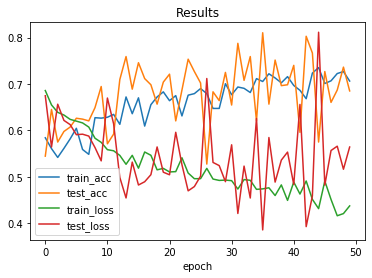

In [0]:
plt.plot(lstm_no_attention.history.history['acc'])
plt.plot(lstm_no_attention.history.history['val_acc'])
plt.plot(lstm_no_attention.history.history['loss'])
plt.plot(lstm_no_attention.history.history['val_loss'])
plt.title('Results')
plt.legend(['train_acc', 'test_acc', 'train_loss', 'test_loss'], loc = 'best')
plt.xlabel('epoch')
# plt.ylabel('accuracy')
plt.show()

In [0]:
# evaluate the keras model
_, accuracy = lstm_no_attention.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

527/527 [==============================] - 12s 23ms/sample - loss: 0.6022 - acc: 0.6148
Accuracy: 61.48


In [0]:
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# baseline model
def create_baseline():
  model = Sequential()
  model.add(Embedding(NUM_CHARS, EMBEDDING_SIZE, input_length=MAX_LENGTH))
  model.add(LSTM(HIDDEN_SIZE))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=1, batch_size=64, verbose=1)
kfold = StratifiedKFold(n_splits=3, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1402 samples
702/702 [==============================] - 5s 7ms/sample - loss: 0.2978 - acc: 0.9145
Train on 1403 samples
701/701 [==============================] - 5s 7ms/sample - loss: 0.2978 - acc: 0.9144
Train on 1403 samples
701/701 [==============================] - 5s 7ms/sample - loss: 0.2973 - acc: 0.9144
Baseline: 91.44% (0.01%)


In [0]:
estimator.predict(X_test)

AttributeError: ignored

In [0]:
# Bidirectional LSTM without Attention (https://keras.io/examples/imdb_bidirectional_lstm/)
bi_lstm_no_attention = Sequential()
bi_lstm_no_attention.add(Embedding(NUM_CHARS, EMBEDDING_SIZE, input_length=MAX_LENGTH))
bi_lstm_no_attention.add(Bidirectional(LSTM(HIDDEN_SIZE)))
# bi_lstm_no_attention.add(Dropout(0.5))
bi_lstm_no_attention.add(Dense(1, activation='sigmoid'))
bi_lstm_no_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(bi_lstm_no_attention.summary())

bi_lstm_no_attention.fit(X_train_main, y_train_main,
                         validation_data=(X_train_val, y_train_val),
                         epochs=10, batch_size=64, class_weight=class_weights_dict)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1695, 64)          8192      
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               132000    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 201       
Total params: 140,393
Trainable params: 140,393
Non-trainable params: 0
_________________________________________________________________
None
Train on 1683 sampl

KeyboardInterrupt: ignored

In [0]:
predictions_bi_lstm_no_attention = evaluate_precision_recall(bi_lstm_no_attention, X_test, y_test)

Precision: 0.9688888888888889
Recall: 0.44948453608247424


In [0]:
# Constants
NUM_CHARS = 128
# SOS_token = 129
# EOS_token = 130
INPUT_SIZE = max_len# + 2
MAX_LENGTH = max_len
HIDDEN_SIZE = 150
EMBEDDING_SIZE = 64
OUTPUT_SIZE = NUM_CHARS + 2
NUM_LAYERS = 2

In [0]:
# Create LSTM with Attention using Keras Functional API
# (https://stackoverflow.com/questions/42918446/how-to-add-an-attention-mechanism-in-keras)
def create_lstm_with_attention():
    _input = Input(shape=[MAX_LENGTH])
    embedded = Embedding(
            input_dim=NUM_CHARS,
            output_dim=EMBEDDING_SIZE,
            input_length=MAX_LENGTH,
            trainable=False,
            mask_zero=False
        )(_input)
    activations = LSTM(HIDDEN_SIZE, return_sequences=True)(embedded)
    # activations = Dropout(0.5)(activations)
    
    # Attention
    attention = Dense(1, activation='tanh')(activations) # 'softmax'
    # attention = Dense(1)(attention)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(HIDDEN_SIZE)(attention)
    attention = Permute([2, 1])(attention)
    output_attention = multiply([activations, attention])

    # output_attention = LSTM(HIDDEN_SIZE)(output_attention)

    output_attention = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(HIDDEN_SIZE,))(output_attention)
    output = Dense(1, activation='softmax')(output_attention)
    lstm_attention = Model(inputs=[_input], outputs=output, name="lstm_attention")
    return lstm_attention

In [0]:
print_weights = LambdaCallback(on_epoch_end=lambda epoch, logs: print(lstm_attention.layers[4].get_weights()))
print_weights_2 = LambdaCallback(on_epoch_end=lambda epoch, logs: print(lstm_attention.layers[10].get_weights()))

print_output = LambdaCallback(on_epoch_end=lambda epoch, logs: print(lstm_attention.layers[6].output))

In [0]:
lstm_attention = create_lstm_with_attention()
# lstm_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
lstm_attention.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(lstm_attention.summary())

lstm_attention.fit(X_train_main, y_train_main,
                         validation_data=(X_train_val, y_train_val),
                         epochs=3, batch_size=64, class_weight=class_weights_dict,
                   callbacks = [print_weights, print_weights_2])

Model: "lstm_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1695)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1695, 64)     8192        input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 1695, 100)    66000       embedding_3[0][0]                
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1695, 1)      101         lstm_3[0][0]                     
_____________________________________________________________________________________

KeyboardInterrupt: ignored

In [0]:
predictions_lstm_attention, rounded_lstm_attention = evaluate_precision_recall(lstm_attention, X_test, y_test)

ZeroDivisionError: ignored

In [0]:
predictions_lstm_attention

In [0]:
rounded_lstm_attention

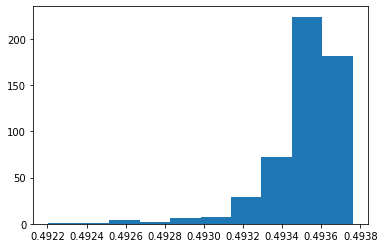

In [0]:
plt.hist(predictions_lstm_attention)
plt.show()

In [0]:
predictions_lstm_attention

array([[0.4961562 ],
       [0.49609172],
       [0.49615976],
       [0.49607486],
       [0.4961688 ],
       [0.49612573],
       [0.49614757],
       [0.4961554 ],
       [0.4961159 ],
       [0.49597448],
       [0.49617523],
       [0.49607423],
       [0.49605054],
       [0.4961135 ],
       [0.49616486],
       [0.49596468],
       [0.4961772 ],
       [0.49618816],
       [0.49549094],
       [0.49612513],
       [0.4961008 ],
       [0.4961989 ],
       [0.49613893],
       [0.49606025],
       [0.49615124],
       [0.49605876],
       [0.4960235 ],
       [0.496061  ],
       [0.49608633],
       [0.49609944],
       [0.49620906],
       [0.49543896],
       [0.49595445],
       [0.4960561 ],
       [0.49603152],
       [0.49607995],
       [0.49614912],
       [0.49606827],
       [0.49612287],
       [0.4961007 ],
       [0.49611697],
       [0.4960754 ],
       [0.49570054],
       [0.49610198],
       [0.49594525],
       [0.49615216],
       [0.49611413],
       [0.496

In [0]:
lstm_attention.layers

In [0]:
for layer in lstm_attention.layers:
    print(layer.output)

Tensor("input_16:0", shape=(?, 1695), dtype=float32)
Tensor("embedding_24/embedding_lookup/Identity_1:0", shape=(?, 1695, 64), dtype=float32)
Tensor("lstm_24/transpose_1:0", shape=(?, 1695, 10), dtype=float32)
Tensor("dense_25/Tanh:0", shape=(?, 1695, 1), dtype=float32)
Tensor("flatten_24/Reshape:0", shape=(?, 1695), dtype=float32)
Tensor("activation_12/Softmax:0", shape=(?, 1695), dtype=float32)
Tensor("repeat_vector_12/Tile:0", shape=(?, 10, 1695), dtype=float32)
Tensor("permute_12/transpose:0", shape=(?, 1695, 10), dtype=float32)
Tensor("multiply_12/mul:0", shape=(?, 1695, 10), dtype=float32)
Tensor("lambda_12/Sum:0", shape=(?, 10), dtype=float32)
Tensor("dense_26/Sigmoid:0", shape=(?, 1), dtype=float32)


In [0]:
# create Bidirectional LSTM with Attention using Keras Functional API
def create_bi_lstm_with_attention():
    _input = Input(shape=[MAX_LENGTH])
    embedded = Embedding(
            input_dim=NUM_CHARS,
            output_dim=EMBEDDING_SIZE,
            input_length=MAX_LENGTH,
            trainable=False,
            mask_zero=False
        )(_input)
    activations = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True))(embedded)
    # Attention
    attention = Dense(1, activation='tanh')(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(2*HIDDEN_SIZE)(attention)
    attention = Permute([2, 1])(attention)
    output_attention = multiply([activations, attention])

    # output_attention = LSTM(HIDDEN_SIZE)(output_attention)
    output_attention = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(HIDDEN_SIZE,))(output_attention)
    output = Dense(1, activation='sigmoid')(output_attention)
    bi_lstm_attention = Model(inputs=[_input], outputs=output, name="bi_lstm_attention")
    return bi_lstm_attention

In [0]:
bi_lstm_attention = create_bi_lstm_with_attention()
bi_lstm_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(bi_lstm_attention.summary())

bi_lstm_attention.fit(X_train_main, y_train_main,
                         validation_data=(X_train_val, y_train_val),
                         epochs=1, batch_size=1024, class_weight=class_weights_dict)

Model: "bi_lstm_attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1695)]       0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 1695, 64)     8192        input_19[0][0]                   
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 1695, 20)     6000        embedding_27[0][0]               
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 1695, 1)      21          bidirectional_2[0][0]            
__________________________________________________________________________________

In [0]:
for layer in bi_lstm_attention.layers:
    print(layer.output)

Tensor("input_19:0", shape=(?, 1695), dtype=float32)
Tensor("embedding_27/embedding_lookup/Identity_1:0", shape=(?, 1695, 64), dtype=float32)
Tensor("bidirectional_2/concat:0", shape=(?, 1695, 20), dtype=float32)
Tensor("dense_30/Tanh:0", shape=(?, 1695, 1), dtype=float32)
Tensor("flatten_28/Reshape:0", shape=(?, 1695), dtype=float32)
Tensor("activation_15/Softmax:0", shape=(?, 1695), dtype=float32)
Tensor("repeat_vector_15/Tile:0", shape=(?, 20, 1695), dtype=float32)
Tensor("permute_15/transpose:0", shape=(?, 1695, 20), dtype=float32)
Tensor("multiply_15/mul:0", shape=(?, 1695, 20), dtype=float32)
Tensor("lambda_13/Sum:0", shape=(?, 20), dtype=float32)
Tensor("dense_31/Sigmoid:0", shape=(?, 1), dtype=float32)


In [0]:
predictions_bi_lstm_attention, rounded_bi_lstm_attention = evaluate_precision_recall(bi_lstm_attention, X_test, y_test)

Precision: 0.920303605313093
Recall: 1.0


In [0]:
predictions_bi_lstm_attention

array([[0.49279505],
       [0.49278334],
       [0.49282378],
       [0.49290022],
       [0.49274424],
       [0.49280027],
       [0.49284464],
       [0.49289772],
       [0.49282852],
       [0.49298853],
       [0.49282432],
       [0.4929398 ],
       [0.49289438],
       [0.49284768],
       [0.4928056 ],
       [0.49273527],
       [0.4928078 ],
       [0.49285936],
       [0.49352923],
       [0.49284142],
       [0.4928773 ],
       [0.49280974],
       [0.49281394],
       [0.49290928],
       [0.4928471 ],
       [0.4927938 ],
       [0.49299645],
       [0.49297532],
       [0.49281278],
       [0.4928103 ],
       [0.49279988],
       [0.49309644],
       [0.49296218],
       [0.49295136],
       [0.4928891 ],
       [0.49289304],
       [0.4927944 ],
       [0.49284866],
       [0.49278468],
       [0.4928492 ],
       [0.49282867],
       [0.4928429 ],
       [0.49317837],
       [0.49278235],
       [0.4929482 ],
       [0.49283925],
       [0.4927866 ],
       [0.492